<a href="https://colab.research.google.com/github/Nishijujuba/python-cookbook-2023-3rd/blob/master/_downloads/4e865243430a47a00d551ca0579a6f6c/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>If you are running this tutorial on Windows or MacOS and encounter aBrokenPipeError or RuntimeError related to multiprocessing, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>

</div>



In [3]:
transform = transforms.Compose( #定义一个“图像预处理流水线”，后面在读数据集时会应用到每一张图片上。#transforms.Compose(把多个 transform 按顺序串起来执行（先做第一个，再做第二个……）。
    [transforms.ToTensor(),#把 PIL 图像转成 PyTorch Tensor，形状变为 (C, H, W)，并把像素从 0–255 转成 float 且缩放到 [0, 1]。
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#对每个通道分别做标准化：这里 mean 和 std 都是 (0.5, 0.5, 0.5)（对应 RGB 三通道）。因此对任意通道 (x-mean)/0.5 会把 [0,1] 大致映射到 [-1,1]。


batch_size = 4 #每次从数据集中取 4 张图片（以及对应标签）组成一个 batch 送进模型。

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #创建 CIFAR-10 训练集对象（是一个 Dataset，支持按索引取样本）; root='./data'数据集下载/存放的目录（相对当前工作路径的 ./data）train=True选择训练集部分（不是测试集）。
                                        download=True, transform=transform)#download=True如果本地没有，就自动下载并解压。transform=transform每次从 trainset 取出一张图片时，都会应用上面定义的预处理流水线（ToTensor + Normalize）。
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,#用 DataLoader 把 Dataset 包装成“可迭代的批数据”，训练时通常写 for inputs, labels in trainloader:;batch_size=batch_size每个 batch 取 4 个样本;
                                          shuffle=True, num_workers=2)#shuffle=True每个 epoch 开始前把训练数据顺序打乱，有助于训练更稳定、减少顺序偏差。num_workers=2用 2 个子进程并行加载/预处理数据

testset = torchvision.datasets.CIFAR10(root='./data', train=False,#train=False选择测试集部分，其他参数同训练集：存放路径、必要时下载、并应用同样的 transform（保证训练/测试输入尺度一致）
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,#shuffle=False测试/评估通常不需要打乱（不影响准确率计算；也方便复现与逐样本对照）。
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')#定义一个长度为 10 的元组：把标签 id（0–9）映射成可读的类别名。例如预测/真实标签是 3，就可以显示成 classes[3] == 'cat'。

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s]


Let us show some of the training images, for fun.


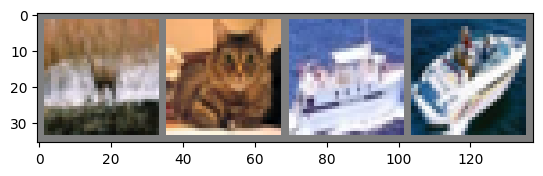

deer  cat   ship  ship 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize：img*0.5 + 0.5 还原 回更适合显示的范围
    npimg = img.numpy()#把 Torch Tensor 转成 NumPy 数组，方便用 NumPy 做维度变换，并传给 Matplotlib。
    plt.imshow(np.transpose(npimg, (1, 2, 0)))#plt.imshow(...)：显示一张图像。 np.transpose(npimg, (1, 2, 0))：把维度从 (C, H, W) 改成 (H, W, C)。#PyTorch 图像 Tensor 常用 C,H,W#Matplotlib 期望 H,W,C
    plt.show()


# get some random training images
dataiter = iter(trainloader)#trainloader 变成一个迭代器
images, labels = next(dataiter)#取第一个 batch： images 形状一般是 (batch_size, 3, 32, 32) labels 形状一般是 (batch_size,)，每个是 0–9 的类别编号。

# show images
imshow(torchvision.utils.make_grid(images))#torchvision.utils.make_grid(images)：把一个 batch 的多张图片拼成“网格大图”（仍是 Tensor，形状类似 (3, H_grid, W_grid)）。把拼好的网格图传给 imshow 进行反归一化、转 NumPy、转维度并显示。
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
"""
打印这个 batch 里每张图的类别名称（用空格连接成一行）。
for j in range(batch_size)：遍历 batch 中的索引 0..batch_size-1。
labels[j]：第 j 张图的类别 id（0–9）。
classes[labels[j]]：把类别 id 映射成字符串名称（如 'cat'）。
f'{...:5s}'：把字符串按宽度 5 左对齐/填充，方便对齐输出。
' '.join(...)：把这些字符串用空格拼接成一行再打印
"""

2. Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [5]:
import torch.nn as nn #导入构建神经网络用的层（Conv2d/Linear/MaxPool2d 等）
import torch.nn.functional as F #导入“函数式”的算子（如 F.relu），不带可学习参数。


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        #第 1 个卷积层：in_channels=3（RGB 三通道，这是从 1 通道改成 3 通道的关键），out_channels=6，卷积核 5×5。
        #形状变化：N×3×32×32 -> N×6×28×28（默认 stride=1、padding=0，所以 32-5+1=28）

        self.pool = nn.MaxPool2d(2, 2)
        #最大池化层：窗口 2×2，步幅 2，用于下采样（宽高减半）。#
        #形状变化（对 28×28）：-> 14×14。

        self.conv2 = nn.Conv2d(6, 16, 5)
        #第 2 个卷积层：输入通道 6，输出通道 16，卷积核 5×5。
        #形状变化：N×6×14×14 -> N×16×10×10（14-5+1=10）。

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #第 1 个全连接层：输入特征数 16*5*5=400，输出 120。
        #这里的 16*5*5 来自后面第二次池化后特征图大小会变成 N×16×5×5。

        self.fc2 = nn.Linear(120, 84)
        #第 2 个全连接层：120 → 84。

        self.fc3 = nn.Linear(84, 10)
        #第 3 个全连接层：84 → 10，对应 CIFAR-10 的 10 个类别输出（logits）。

    def forward(self, x):#定义前向传播：输入 x 的典型形状是 N×3×32×32。
        x = self.pool(F.relu(self.conv1(x)))
        #先卷积 conv1，再 ReLU 激活，再 MaxPool 下采样。
        #形状：N×3×32×32 -> conv1 -> N×6×28×28 -> pool -> N×6×14×14。

        x = self.pool(F.relu(self.conv2(x)))
        #再卷积 conv2，ReLU，池化。
        #形状：N×6×14×14 -> conv2 -> N×16×10×10 -> pool -> N×16×5×5。

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #展平：从第 1 维开始展平（保留 batch 维 N 不动）。
        #形状：N×16×5×5 -> N×400。

        x = F.relu(self.fc1(x))
        #全连接 fc1 后接 ReLU：N×400 -> N×120。

        x = F.relu(self.fc2(x))
        #fc2 后接 ReLU：N×120 -> N×84。

        x = self.fc3(x)
        #最后一层线性输出 logits：N×84 -> N×10（通常不在这里做 softmax，训练时配合 CrossEntropyLoss 直接用 logits）。
        return x


net = Net()

3. Define a Loss function and optimizer
=======================================

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [6]:
import torch.optim as optim #导入 PyTorch 的优化器模块（里面有 SGD、Adam 等）。

criterion = nn.CrossEntropyLoss()
#定义损失函数 交叉熵，用于多分类任务。
#训练时通常把模型输出的 logits（形状 [N, 10]）和标签 labels（形状 [N]，取值 0–9）喂给它：loss = criterion(outputs, labels)。
#说明：CrossEntropyLoss 内部等价于 log_softmax + NLLLoss，所以模型最后一层一般不需要自己再做 softmax。

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#定义优化器：使用 随机梯度下降 SGD 来更新 net 的所有可训练参数。
#net.parameters()：告诉优化器要更新哪些参数（来自模型里各层的 weight/bias）。
#lr=0.001：学习率，每次更新步子的大小。
#momentum=0.9：动量项，让更新方向带“惯性”，通常能加速收敛并减少震荡。

4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [7]:
#下面按行解释这段训练循环（它做的事：取 batch → 前向 → 计算损失 → 反向传播 → 更新参数）。

for epoch in range(2):  # loop over the dataset multiple times
#外层循环训练轮数（epoch）。range(2) 表示训练 2 个 epoch：epoch 依次为 0、1。

    running_loss = 0.0
    #用来累计一段时间内的损失，方便每隔固定步数打印平均 loss。

    for i, data in enumerate(trainloader, 0):
    #遍历训练数据加载器 trainloader，每次取一个 batch。
    #enumerate(..., 0) 给每个 batch 一个计数 i（从 0 开始）。
    #data 是一个 batch，里面包含输入和标签。

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs：形状通常是 [batch_size, 3, 32, 32]
        #labels：形状通常是 [batch_size]，每个值是类别 id（0–9）

        # zero the parameter gradients
        optimizer.zero_grad()
        #把上一轮/上一次 step 计算留下的梯度清零。

        # forward + backward + optimize
        outputs = net(inputs)
        #前向传播：把 inputs 喂给网络得到输出 outputs（logits）。
        #outputs 形状通常是 [batch_size, 10]。


        loss = criterion(outputs, labels)
        #计算损失（交叉熵）。用模型输出 logits 和真实标签算出一个标量 loss。

        loss.backward()
        #反向传播：根据 loss 计算所有可训练参数的梯度，并存入各参数的 .grad。

        optimizer.step()
        #参数更新：使用 SGD（带 momentum）按照梯度更新 net.parameters() 里的参数。

        # print statistics
        running_loss += loss.item()
        #loss.item() 把 0 维张量 loss 转成 Python 浮点数，累加到 running_loss。

        if i % 2000 == 1999:    # print every 2000 mini-batches
        #每处理 2000 个 mini-batch 打印一次（因为从 0 开始计数，所以第 1999、3999、... 次触发）。
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #打印训练进度与平均损失：
            #epoch + 1：把 epoch 从 0/1 显示成 1/2
            #i + 1:5d：把 step 编号按宽度 5 的整数格式对齐显示
            #running_loss / 2000：最近 2000 个 batch 的平均 loss
            #:.3f：保留 3 位小数

            running_loss = 0.0
            #打印后把累计损失清零，开始统计下一段 2000 个 batch。

print('Finished Training')

[1,  2000] loss: 2.191
[1,  4000] loss: 1.857
[1,  6000] loss: 1.652
[1,  8000] loss: 1.565
[1, 10000] loss: 1.498
[1, 12000] loss: 1.459
[2,  2000] loss: 1.383
[2,  4000] loss: 1.352
[2,  6000] loss: 1.328
[2,  8000] loss: 1.314
[2, 10000] loss: 1.279
[2, 12000] loss: 1.267
Finished Training


Let\'s quickly save our trained model:


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


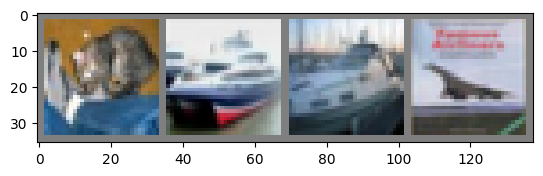

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)#把 testloader（可迭代的 DataLoader）变成一个迭代器，便于用 next() 取出一批数据。
#从测试集取出一个 batch：images 是图像张量，labels 是对应类别 id。
#常见形状：images 为 [B, 3, 32, 32]，labels 为 [B]。

# print images
imshow(torchvision.utils.make_grid(images))#把一个 batch 的多张图片拼成网格图
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [10]:
net = Net()
#这一步会创建网络结构，并初始化参数（通常是随机初始化，除非你在 __init__ 里自定义初始化）

net.load_state_dict(torch.load(PATH, weights_only=True))
#torch.load(PATH, weights_only=True)：从 PATH 指向的文件里读取保存的“权重/参数字典”（state_dict）。
#PATH 一般是你之前 torch.save(net.state_dict(), PATH) 保存出来的文件路径。
#weights_only=True（较新的 PyTorch 参数）：表示只按“权重数据”方式加载，更安全、也更符合只加载参数的用途（避免反序列化任意对象的风险）。
#net.load_state_dict(...)：把读出来的参数逐层拷贝进 net 里，使 net 恢复到保存时的权重。


'''
设备一致性：如果权重保存在 GPU 上、你现在在 CPU 加载，常用 torch.load(PATH, map_location="cpu", weights_only=True)。
推理模式：加载后做测试一般再加 net.eval()（关闭 dropout、使用 BN 的 running 统计）。
'''


<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [11]:
outputs = net(images)

In [12]:
print(outputs)
#grad_fn=<AddmmBackward0> 表示这个张量来自可求导计算图（因为此时没包在 torch.no_grad()

tensor([[-0.2124, -3.8113,  2.5935,  3.0411,  1.0501,  0.6015,  2.9216, -2.5337,
         -0.1424, -2.0841],
        [ 3.1366,  1.4841,  0.5889, -1.1935, -1.1038, -2.2314, -2.3986, -3.2444,
          4.1073,  0.1381],
        [ 2.2784,  0.2980,  0.6584, -0.7881, -0.4891, -1.5342, -1.4844, -2.1347,
          2.6371, -0.0263],
        [ 3.6141, -1.2620,  1.7285, -0.7016, -0.0083, -1.8696, -1.6052, -2.0804,
          2.5664, -0.6496]], grad_fn=<AddmmBackward0>)


The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [13]:
_, predicted = torch.max(outputs, 1)
#torch.max(outputs, 1)：沿着维度 1（类别维度）取最大值。
#返回两个东西：
#_：每行的最大值（这里你不关心，所以用 _ 丢掉）
#predicted：每行最大值所在的索引（也就是预测类别 id），形状 [B]

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
#细节：在一些环境里更稳妥的写法是 classes[predicted[j].item()]（把 0 维张量转成 Python int）。

Predicted:  cat   ship  ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [14]:
correct = 0 #correct：累计预测正确的样本数
total = 0 #total：累计测试过的样本总数

# since we're not training, we don't need to calculate the gradients for our outputs

with torch.no_grad():
#进入“无梯度”模式：不构建计算图、不存梯度，推理更省显存更快。
    for data in testloader:
    #遍历测试集的每个 batch。
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        #得到每张图的预测类别 id

        total += labels.size(0)
        #本 batch 有多少张图就加多少到 total（labels.size(0) 就是 batch size）。

        correct += (predicted == labels).sum().item()
        #predicted == labels 得到布尔张量（对/错）。
        #.sum() 统计 True 的个数（本 batch 正确数）。
        #.item() 转 Python 数字再累加。

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


#测试前通常会加 net.eval()（关闭 dropout、让 BN 用 running 统计）。教程里有时省略，但实际更规范：

Accuracy of the network on the 10000 test images: 50 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
#correct_pred[类名]：该类预测正确的数量
total_pred = {classname: 0 for classname in classes}
#total_pred[类名]：该类样本总数量


# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
          #对 batch 内的每个样本逐个统计：
          #label：真实类别 id
          #prediction：预测类别 id
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.8 %
Accuracy for class: car   is 53.6 %
Accuracy for class: bird  is 65.5 %
Accuracy for class: cat   is 38.7 %
Accuracy for class: deer  is 34.6 %
Accuracy for class: dog   is 22.4 %
Accuracy for class: frog  is 78.0 %
Accuracy for class: horse is 45.1 %
Accuracy for class: ship  is 68.8 %
Accuracy for class: truck is 35.6 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
===============

Just like how you transfer a Tensor onto the GPU, you transfer the
neural net onto the GPU.

Let\'s first define our device as the first visible cuda device if we
have CUDA available:


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert
their parameters and buffers to CUDA tensors:

``` {.python}
net.to(device)
```

Remember that you will have to send the inputs and targets at every step
to the GPU too:

``` {.python}
inputs, labels = data[0].to(device), data[1].to(device)
```

Why don\'t I notice MASSIVE speedup compared to CPU? Because your
network is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first `nn.Conv2d`, and argument 1 of the second `nn.Conv2d` -- they
need to be the same number), see what kind of speedup you get.

**Goals achieved**:

-   Understanding PyTorch\'s Tensor library and neural networks at a
    high level.
-   Train a small neural network to classify images

Training on multiple GPUs
=========================

If you want to see even more MASSIVE speedup using all of your GPUs,
please check out `data_parallel_tutorial`{.interpreted-text role="doc"}.

Where do I go next?
===================

-   `Train neural nets to play video games </intermediate/reinforcement_q_learning>`{.interpreted-text
    role="doc"}
-   [Train a state-of-the-art ResNet network on
    imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
-   [Train a face generator using Generative Adversarial
    Networks](https://github.com/pytorch/examples/tree/master/dcgan)
-   [Train a word-level language model using Recurrent LSTM
    networks](https://github.com/pytorch/examples/tree/master/word_language_model)
-   [More examples](https://github.com/pytorch/examples)
-   [More tutorials](https://github.com/pytorch/tutorials)
-   [Discuss PyTorch on the Forums](https://discuss.pytorch.org/)
-   [Chat with other users on
    Slack](https://pytorch.slack.com/messages/beginner/)


In [ ]:
del dataiter